# Run LD-score regression on cell type markers

In [1]:
import anndata as ad
import pandas as pd
import numpy as np
import os
import scanpy as sc

In [3]:
#import cellink

In [16]:
# helper function to subset cells
def get_n_cells_per_group(adata, group_keys, max_n_cells, min_n_cells=30):
    df = adata.obs.copy()
    l=[]
    for group_key,df1 in df.groupby(group_keys, observed=True):

        if (len(df1)<min_n_cells):
            print(f'Not including group {group_key} because it has only {len(df1)} cells')
        elif (len(df1)<max_n_cells):
            l.append(df1)
        else:
            l.append(df1.sample(max_n_cells,random_state=42))

    df_concat = pd.concat(l,axis=0)
    adata_red = adata[df_concat.index,:]
    
    return adata_red

In [40]:
# function to get gene sets per cell type
def add_ct_gene_sets(
    adata: ad.AnnData,
    ct_key: str,
    n_top_genes: int = 500,
    ensemble_id_col: str = 'gene_ids',
    gene_name_col: str = 'gene_names',
    rgg_key: str = 'rank_genes_groups',
    exclude_hla: bool = True,
    add_geneset_dfs = False
) -> ad.AnnData | None:
    
    """
    Extracts cell type marker gene sets used as input for LD-score regression analysis.
    Leverages output of scanpy.tl.rank_genes_groups.
    ----------
    adata : anndata.AnnData
        AnnData object containing DE results of sc.tl.rank_genes_groups per cell type
    ct_key : str
        Column identifier in adata.obs containing cell type labels
    n_top_genes : int
        Number of top differentially expressed genes per cell type
    ensemble_id_col : str
        Column identifier in adata.obs containing ENSEMBLE IDs
    gene_name_col : str
        Column identifier in adata.obs containing gene names
    rgg_key : str
        Key in adata.uns containing results of sc.tl.rank_genes_groups
    exclude_hla : bool
        If True, genes starting with 'HLA-' are removed.
    add_geneset_dfs : bool, optional
        If True, pd.DataFrames containing the DE results of the n_top_genes 
        are added to adata.uns['ldsc']['gene_set_dfs']
    

    Returns
    -------
    adata object with cell type specific gene sets added in
    adata.varm['ct_gene_sets']. Parameters are stored in adata.uns['ldsc']
    """

    # Ensure rank_genes_groups was run
    if adata.uns[rgg_key]['params']['groupby'] != ct_key:
        raise ValueError(
                f"rank_genes_groups was run on different groupby column. Found {adata.uns[rgg_key]['params']['groupby']}, expected {ct_key}."
            )
        
    # Check presence of gene_id column in adata.var
    if ensemble_id_col not in list(adata.var.columns):
        raise ValueError(
            f"Ensemble IDs not found in adata.var.columns. ensemble_id_col is set to {ensemble_id_col}."
        )

    # Check presence of gene_names column in adata.var
    if gene_name_col not in list(adata.var.columns):
        raise ValueError(
                f"Gene names not found in adata.var.columns. Please add or change column identifier for gene_name_col."
            )
        
    # get cell type specific genes
    de_result_dict = {}

    # Extract DE results and add ensemble ID if needed
    for ct in adata.obs[ct_key].unique():
        
        # extract dea dataframe and store to csv
        dea_df = sc.get.rank_genes_groups_df(adata, group=ct, key=rgg_key,)
        
        # add ensemble ids and gene names consistently if needed
        if dea_df.names[0].startswith('ENS'):
            dea_df[ensemble_id_col] = dea_df.names
            ens_id_to_gene_names = dict(zip(adata.var[ensemble_id_col], adata.var[gene_name_col]))
            dea_df[gene_name_col] = dea_df[ensemble_id_col].map(ens_id_to_gene_names)   
        else:
            # add column with mapped ensemble ids
            dea_df[gene_name_col] = dea_df.names
            gene_name_to_ens_id = dict(zip(adata.var[gene_name_col], adata.var[ensemble_id_col]))
            dea_df[ensemble_id_col] = dea_df[gene_name_col].map(gene_name_to_ens_id)      
        
        # exclude HLA genes, since they have funny LD patterns
        if exclude_hla:
            dea_df = dea_df.loc[~dea_df[gene_name_col].str.startswith("HLA-"), :]
        
        # Sort genes by score
        dea_df_final = dea_df.sort_values(by="scores", ascending=False).iloc[:n_top_genes]

        # TODO: Reduce to only significantly expressed genes
    
        # make sure these do not include genes with negative t statistics
        if (dea_df_final.scores < 0).any():
            raise ValueError(
                f"Note that the top {n_top_genes} of your DEA are partly lower-expressed genes! You might want to check."
            )
        
        # remove spaces from cell type name
        ct_no_spaces = ct.replace(" ", "_")
        ct_no_spaces = ct_no_spaces.replace("/", "_")
        # save result df
        de_result_dict[ct_no_spaces] = dea_df_final

    # Add results to adata.varm
    de_result_dict_bool = {}
    for ct in list(de_result_dict.keys()):
        de_result_dict_bool[ct] = [g in list(de_result_dict[ct][ensemble_id_col]) for g in adata.var[ensemble_id_col]]
    
    adata.varm['ct_gene_sets'] = pd.DataFrame(de_result_dict_bool, index=adata.var_names)
    # Save parameters
    adata.uns['ldsc'] = {'params':{
        'ct_key':ct_key,
        'n_top_genes':n_top_genes,
        'ensemble_id_col':ensemble_id_col,
        'gene_name_col':gene_name_col,
        'rgg_key':rgg_key,
        'exclude_hla':exclude_hla,
        'add_geneset_dfs':add_geneset_dfs
    }}

    if add_geneset_dfs:
        adata.uns['ldsc']['geneset_dfs'] = de_result_dict
    
    return(0)
    

In [61]:
def save_ldsc_gene_sets(
    adata: ad.AnnData,
    save_dir: str,
    ensemble_id_col: str = 'gene_ids',
    gene_name_col: str = 'gene_names',
    ):

    
    # ensure ensemble_id and gene names are in 
    if ensemble_id_col not in list(adata.var.columns):
        raise ValueError(
                f"ensemble_id_col not in adata.var.columns."
            )
    if gene_name_col not in list(adata.var.columns):
        raise ValueError(
                f"gene_name_col not in adata.var.columns."
            )

    # ensure add_ct_gene_sets was run
    if adata.varm['ct_gene_sets']
        
    # save de genes
    for ct in adata.varm['ct_gene_sets'].columns:
        adata.var['gene_id'][adata.varm['ct_gene_sets'][ct]].to_csv(
            os.path.join(save_dir, f"{ct}.GeneSet"),
            index=False,
            header=False
        )
                
    with open(os.path.join(save_dir, "control.GeneSet"), "w+") as f:
        for gene_name, ens_id in zip(adata.var[gene_name_col], adata.var[ensemble_id_col]):
            # exclude HLA genes
            if not gene_name.startswith("HLA-"):
                f.write(ens_id + "\n")
  

## Load data

In [64]:
# check and set working directory
os.getcwd()

'/Users/christopher.lance/PhD/projects'

In [9]:
os.chdir('/Users/christopher.lance/PhD/projects/')

In [10]:
# Load data
pbmc_ad = ad.read_h5ad('hackathon24/data/Yazar_OneK1K/OneK1K_cohort_gene_expression_matrix_14_celltypes.h5ad.gz')

## Inspect adata file and cell type resolution suitabile for LD-score regression per cell type

To obtain robust DE gene sets per cell type, a resolution should be chosen, which allows at least 50 (or better 100) cells per cell type. For large datasets, we can subsample to 500-1500 cells per celltype to reduce comutational ressources to obtain DE genes per cell type.

In [65]:
pbmc_ad

AnnData object with n_obs × n_vars = 1272489 × 32738
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'pool', 'individual', 'percent.mt', 'latent', 'nCount_SCT', 'nFeature_SCT', 'cell_type', 'cell_label', 'sex', 'age'
    var: 'GeneSymbol', 'features'

In [66]:
# Check how many cells there are per cell type
ct_column = 'cell_label'
pbmc_ad.obs[ct_column].value_counts()

cell_label
CD4 NC          463528
CD8 ET          205077
NK              159820
CD8 NC          133482
B IN             82068
CD4 ET           61786
B Mem            48023
Mono C           38233
CD8 S100B        34528
Mono NC          15166
NK R              9677
DC                8690
CD4 SOX4          4065
Platelets         4041
Plasma            3625
Erythrocytes       680
Name: count, dtype: int64

In [18]:
# Subsample to 1000 cells per cell type
pbmc_subsamp = get_n_cells_per_group(pbmc_ad,
                                     group_keys=[ct_column],
                                     max_n_cells=1000,
                                     min_n_cells=30
                                    )

In [19]:
pbmc_subsamp

View of AnnData object with n_obs × n_vars = 15680 × 32738
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'pool', 'individual', 'percent.mt', 'latent', 'nCount_SCT', 'nFeature_SCT', 'cell_type', 'cell_label', 'sex', 'age'
    var: 'GeneSymbol', 'features'

In [20]:
pbmc_subsamp.obs[ct_column].value_counts()

cell_label
B IN            1000
B Mem           1000
CD4 ET          1000
CD4 NC          1000
CD4 SOX4        1000
CD8 ET          1000
CD8 NC          1000
CD8 S100B       1000
DC              1000
Mono C          1000
Mono NC         1000
NK              1000
Plasma          1000
NK R            1000
Platelets       1000
Erythrocytes     680
Name: count, dtype: int64

Ensure adata.X is log normalized

In [22]:
# Check whether adata.X contains counts or normalized values
pbmc_ad.X[:100].toarray()[pbmc_ad.X[:100].toarray()>0]

array([ 1.,  1.,  1., ...,  9., 24.,  1.])

We use log-normalized values as input to receive marker genes per cell type. Additionally, for visualization purposes, we obtain highly variable genes and creata a UMAP of our input data.

In [23]:
pbmc_subsamp.layers['count'] = pbmc_subsamp.X.copy()

/var/folders/fq/vhljg0vx24qb_fvx7tbd6d_80000gn/T/ipykernel_56150/930416120.py:1: ImplicitModificationWarning: Setting element `.layers['count']` of view, initializing view as actual.
  pbmc_subsamp.layers['count'] = pbmc_subsamp.X.copy()


In [24]:
sc.pp.normalize_total(pbmc_subsamp, target_sum=1e4)

In [25]:
sc.pp.log1p(pbmc_subsamp)

In [51]:
sc.pp.highly_variable_genes(pbmc_subsamp,
                            n_top_genes=2000
                           )

In [52]:
print('Running PCA...')
sc.pp.pca(pbmc_subsamp)
print('Running Neighbors...')
sc.pp.neighbors(pbmc_subsamp)
print('Running PCA...')
sc.tl.umap(pbmc_subsamp)

Running PCA...
Running Neigh...


/Users/christopher.lance/miniforge3/envs/sc_genetics/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running PCA...


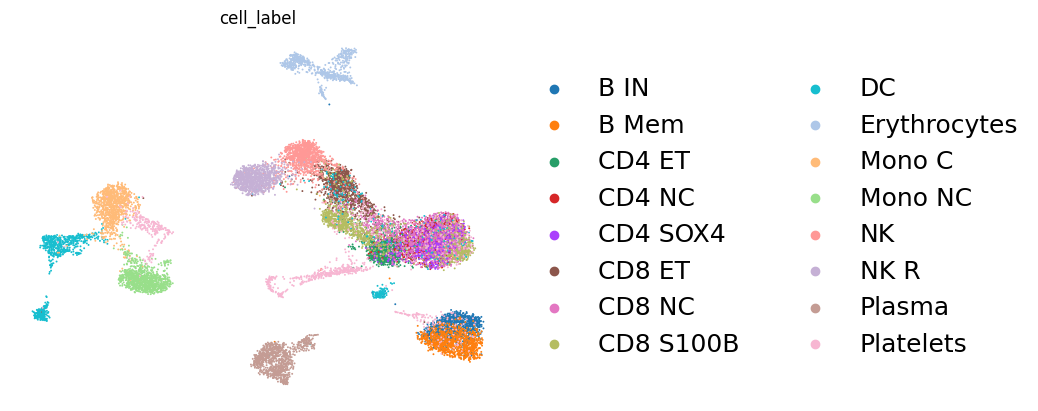

In [53]:
sc.pl.umap(pbmc_subsamp,
           color='cell_label',
           frameon=False,
           legend_fontsize=18
          )

## Get DE genes per cell type

Next, we run sc.tl.rank_genes_groups to obtain marker genes per cell type.

In [27]:
sc.tl.rank_genes_groups(
    pbmc_subsamp, groupby=ct_column, use_raw=False, method="wilcoxon"
)

We add ensemble and gene names as columns to adata.var. This ensures that both IDs types are available. ENSEMBLE IDs are needed to run LDSC, while gene names can be used to filter genes such as HLA- genes.

In [28]:
pbmc_subsamp.var.head()

GeneSymbol       features
Geneid                                       
ENSG00000243485     MIR1302-10     MIR1302-10
ENSG00000237613        FAM138A        FAM138A
ENSG00000186092          OR4F5          OR4F5
ENSG00000238009   RP11-34P13.7   RP11-34P13.7
ENSG00000239945   RP11-34P13.8   RP11-34P13.8

In [29]:
pbmc_subsamp.var['gene_id'] = pbmc_subsamp.var_names

In [31]:
pbmc_subsamp.var.head()

GeneSymbol       features          gene_id
Geneid                                                        
ENSG00000243485     MIR1302-10     MIR1302-10  ENSG00000243485
ENSG00000237613        FAM138A        FAM138A  ENSG00000237613
ENSG00000186092          OR4F5          OR4F5  ENSG00000186092
ENSG00000238009   RP11-34P13.7   RP11-34P13.7  ENSG00000238009
ENSG00000239945   RP11-34P13.8   RP11-34P13.8  ENSG00000239945

Get DE genes and save as files.

In [33]:
pbmc_subsamp

AnnData object with n_obs × n_vars = 15680 × 32738
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'pool', 'individual', 'percent.mt', 'latent', 'nCount_SCT', 'nFeature_SCT', 'cell_type', 'cell_label', 'sex', 'age'
    var: 'GeneSymbol', 'features', 'gene_id'
    uns: 'log1p', 'rank_genes_groups'
    layers: 'count'

Now we extract gene sets per cell type and save it in adata.varm

In [46]:
add_ct_gene_sets(
    pbmc_subsamp,
    ct_key=ct_column,
    n_top_genes=500,
    ensemble_id_col='gene_id',
    gene_name_col='GeneSymbol',
    add_geneset_dfs=True # This saves the DE test results of the selected genes as easy to acces dataframes per cell type to adata.uns.
    )

0

In [55]:
pbmc_subsamp

AnnData object with n_obs × n_vars = 15680 × 32738
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'pool', 'individual', 'percent.mt', 'latent', 'nCount_SCT', 'nFeature_SCT', 'cell_type', 'cell_label', 'sex', 'age'
    var: 'GeneSymbol', 'features', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'rank_genes_groups', 'ldsc', 'hvg', 'pca', 'neighbors', 'umap', 'cell_label_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'ct_gene_sets', 'PCs'
    layers: 'count'
    obsp: 'distances', 'connectivities'

In [63]:
save_ldsc_gene_sets(
                    pbmc_subsamp,
                    save_dir='hackathon24/data/out/gene_sets2',
                    ensemble_id_col='gene_id',
                    gene_name_col='GeneSymbol'
                   )

## Load summary statistics and ensure right format

Here, we take a look at the file format of GWAS summary statistics of a phenotype of interst and run the data preparation script of the ldsc package to ensure the right format.

In [57]:
import subprocess

In [55]:
sum_stats = pd.read_csv('hackathon24/data/sumstats/imsgc_mssev_discovery/imsgc_mssev_discovery.tsv',
                        sep='\t'
                       )

In [65]:
# Check the columns
sum_stats.head()

CHR          SNP     POS A1 A2   AF1      BETA        SE         P  \
0    1   rs12238997  693731  G  A  0.11 -0.000213  0.025786  0.993420   
1    1   rs72631875  705882  A  G  0.06  0.007343  0.036925  0.842370   
2    1   rs55727773  706368  G  A  0.45 -0.023145  0.019553  0.236515   
3    1  rs116030099  722670  C  T  0.09 -0.014475  0.031119  0.641827   
4    1    rs4951859  729679  G  C  0.74 -0.007695  0.023649  0.744893   

        Rsq  
0  0.576052  
1  0.461674  
2  0.661577  
3  0.482130  
4  0.509823

In [69]:
# Define the name of the environment
env_name = "ldsc"

# Use conda to activate the environment and run the command
command = f"""
source $(conda info --base)/etc/profile.d/conda.sh && \
conda activate {env_name} && \
cd /Users/christopher.lance/PhD/projects/hackathon24 && \
./ldsc/munge_sumstats.py \
    --sumstats data/sumstats/imsgc_mssev_discovery/imsgc_mssev_discovery.tsv.gz \
    --N 12584 \
    --a1 A1 \
    --a2 A2 \
    --chunksize 500000 \
    --out data/out/sumstats_clean/imsgc_mssev_discovery
"""

# Run the command in a subprocess
subprocess.run(command, shell=True, executable="/bin/bash")

*********************************************************************
* LD Score Regression (LDSC)
* Version 1.0.1
* (C) 2014-2019 Brendan Bulik-Sullivan and Hilary Finucane
* Broad Institute of MIT and Harvard / MIT Department of Mathematics
* GNU General Public License v3
*********************************************************************
Call: 
./munge_sumstats.py \
--out data/out/sumstats_clean/imsgc_mssev_discovery \
--chunksize 500000 \
--N 12584.0 \
--a1 A1 \
--a2 A2 \
--sumstats data/sumstats/imsgc_mssev_discovery/imsgc_mssev_discovery.tsv.gz 

Interpreting column names as follows:
A1:	Allele 1, interpreted as ref allele for signed sumstat.
P:	p-Value
BETA:	[linear/logistic] regression coefficient (0 --> no effect; above 0 --> A1 is trait/risk increasing)
A2:	Allele 2, interpreted as non-ref allele for signed sumstat.
SNP:	Variant ID (e.g., rs number)

Reading sumstats from data/sumstats/imsgc_mssev_discovery/imsgc_mssev_discovery.tsv.gz into memory 500000 SNPs at a time.
...

CompletedProcess(args='\nsource $(conda info --base)/etc/profile.d/conda.sh && conda activate ldsc && cd /Users/christopher.lance/PhD/projects/hackathon24 && ./ldsc/munge_sumstats.py     --sumstats data/sumstats/imsgc_mssev_discovery/imsgc_mssev_discovery.tsv.gz     --N 12584     --a1 A1     --a2 A2     --chunksize 500000     --out data/out/sumstats_clean/imsgc_mssev_discovery\n', returncode=0)

## Run ldsc per chromosome and celltype

In [89]:
import gzip

### Prep gene coordinate file

Another input needed for LDSC is a coordinate file of all genes, here we create one based on a gtf file of a recent genome version.

In [117]:
# Function to parse GTF (gzip) and generate the coordinate file
def parse_gtf(gtf_file):
    gene_data = []

    # Open the gzip file in read mode
    with gzip.open(gtf_file, 'rt') as f:  # 'rt' for reading text mode
        for line in f:
            # Skip header lines
            if line.startswith('#'):
                continue

            # Split the line into fields
            fields = line.strip().split('\t')
            
            # We're only interested in 'gene' feature type lines
            feature_type = fields[2]
            if feature_type != 'gene':
                continue

            # Extract relevant fields
            chrom = fields[0].replace('chr', '')  # Remove 'chr' prefix
            start = int(fields[3])
            end = int(fields[4])
            strand = fields[6]
            attributes = fields[8]

            # Parse attributes to extract gene_id (Ensembl ID)
            attr_dict = {}
            for attribute in attributes.split(';'):
                if attribute.strip():
                    key, value = attribute.strip().split(' ')
                    attr_dict[key] = value.strip('"')

            # Use Ensembl gene_id, and remove version number
            gene_id = attr_dict.get('gene_id').split('.')[0]

            # Determine TSS and TES - TODO: double check if strand is an issue
            tss = start
            tes = end

            # Append to gene_data list
            gene_data.append([gene_id, chrom, tss, tes])

    # Convert to DataFrame
    df = pd.DataFrame(gene_data, columns=['GENE', 'CHR', 'START', 'END'])

    return df

In [118]:
# Example usage
gtf_file = "hackathon24/data/ld_ressources/gencode.v45.annotation.gtf.gz"
df = parse_gtf(gtf_file)

In [119]:
df.head()

GENE CHR  START    END
0  ENSG00000290825   1  11869  14409
1  ENSG00000223972   1  12010  13670
2  ENSG00000227232   1  14696  24886
3  ENSG00000278267   1  17369  17436
4  ENSG00000243485   1  29554  31109

In [120]:
# Write the DataFrame to a file
df.to_csv("hackathon24/data/ld_ressources/ENSG_coord.txt",
          sep='\t',
          index=False)

### Create ldsc annot files per cell type and chromosome

In [121]:
# define lists of celltypes and chromosomes
ct_list = list(ct_de_res_dict.keys())
chrom_list = [str(i+1) for i in range(22)]

In [70]:
# add the control set to the cell type list
ct_list = ct_list+['control']

In [125]:
# Define the name of the conda environment
env_name = "ldsc"

In [127]:
for ct_name  in ct_list:
    for chrom in chrom_list:
        print('Running ', ct_name, 'on chromosome', chrom)
        
        command = f"""
        source $(conda info --base)/etc/profile.d/conda.sh && \
        conda activate {env_name} && \
        cd /Users/christopher.lance/PhD/projects/hackathon24 && \
        ./ldsc/make_annot.py \
            --gene-set-file data/out/gene_sets/{ct_name}.GeneSet \
        	--gene-coord-file data/ld_ressources/ENSG_coord.txt \
        	--windowsize 100000 \
        	--bimfile data/ld_ressources/1000G_EUR_Phase3_plink/1000G.EUR.QC.{chrom}.bim \
        	--annot-file data/out/annots/{ct_name}.{chrom}.annot.gz
        """
        
        # Run the command in a subprocess
        subprocess.run(command, shell=True, executable="/bin/bash")

Running  B_IN on chromosome 1
making gene set bed file
making annot file
Running  B_IN on chromosome 2
making gene set bed file
making annot file
Running  B_IN on chromosome 3
making gene set bed file
making annot file
Running  B_IN on chromosome 4
making gene set bed file
making annot file
Running  B_IN on chromosome 5
making gene set bed file
making annot file
Running  B_IN on chromosome 6
making gene set bed file
making annot file
Running  B_IN on chromosome 7
making gene set bed file
making annot file
Running  B_IN on chromosome 8
making gene set bed file
making annot file
Running  B_IN on chromosome 9
making gene set bed file
making annot file
Running  B_IN on chromosome 10
making gene set bed file
making annot file
Running  B_IN on chromosome 11
making gene set bed file
making annot file
Running  B_IN on chromosome 12
making gene set bed file
making annot file
Running  B_IN on chromosome 13
making gene set bed file
making annot file
Running  B_IN on chromosome 14
making gene set 

### Calculate l2 scores

In [18]:
for ct_name  in ct_list:
    for chrom in chrom_list:
        print('Running ', ct_name, 'on chromosome', chrom)
        command = f"""
            source $(conda info --base)/etc/profile.d/conda.sh && \
            conda activate {env_name} && \
            cd /Users/christopher.lance/PhD/projects/hackathon24 && \
            ./ldsc/ldsc.py \
                --l2 \
                --bfile data/ld_ressources/1000G_EUR_Phase3_plink/1000G.EUR.QC.{chrom} \
                --ld-wind-cm 1 \
                --annot data/out/annots/{ct_name}.{chrom}.annot.gz \
                --thin-annot \
                --out data/out/annots/{ct_name}.{chrom} \
                --print-snps data/ld_ressources/hm3_no_MHC.list.txt
            """
            
        # Run the command in a subprocess
        subprocess.run(command, shell=True, executable="/bin/bash")

Running  B_IN on chromosome 1
*********************************************************************
* LD Score Regression (LDSC)
* Version 1.0.1
* (C) 2014-2019 Brendan Bulik-Sullivan and Hilary Finucane
* Broad Institute of MIT and Harvard / MIT Department of Mathematics
* GNU General Public License v3
*********************************************************************
Call: 
./ldsc.py \
--print-snps data/ld_ressources/hm3_no_MHC.list.txt \
--ld-wind-cm 1.0 \
--out data/out/annots/B_IN.1 \
--bfile data/ld_ressources/1000G_EUR_Phase3_plink/1000G.EUR.QC.1 \
--thin-annot  \
--annot data/out/annots/B_IN.1.annot.gz \
--l2  

Beginning analysis at Thu Oct 10 16:27:04 2024
Read list of 779354 SNPs from data/ld_ressources/1000G_EUR_Phase3_plink/1000G.EUR.QC.1.bim
Read 1 annotations for 779354 SNPs from data/out/annots/B_IN.1.annot.gz
Read list of 489 individuals from data/ld_ressources/1000G_EUR_Phase3_plink/1000G.EUR.QC.1.fam
Reading genotypes from data/ld_ressources/1000G_EUR_Phase3_plink

Create a reference file, that lists all celltypes for the analysis

In [275]:
ct_list

['B_IN',
 'B_Mem',
 'CD4_ET',
 'CD4_NC',
 'CD4_SOX4',
 'CD8_ET',
 'CD8_NC',
 'CD8_S100B',
 'DC',
 'Erythrocytes',
 'Mono_C',
 'Mono_NC',
 'NK',
 'NK_R',
 'Plasma',
 'Platelets',
 'control']

In [277]:
# drop control of cell type list
ct_list = [ct for ct in ct_list if ct!='control']

In [289]:
annot_path = f'data/out/annots/'
control_path = 'data/out/annots/control.' # directory were ldsc is run
ct_ref_file = 'hackathon24/data/out/cts.ldcts' # output file from current wd

# generate list of paths for cell types and controls
path_list = [f'{annot_path}{ct}.,{control_path}' for ct in ct_list]

In [290]:
path_df = pd.DataFrame({'celltype':ct_list, 'paths':path_list})

In [292]:
path_df.to_csv(ct_ref_file, sep='\t', header=False, index=False)

Run sc-LDSC regression on GWAS summary statistics

In [293]:
dataset_name = 'imsgc_mssev_discovery'

In [294]:
command = f"""
    source $(conda info --base)/etc/profile.d/conda.sh && \
    conda activate {env_name} && \
    cd /Users/christopher.lance/PhD/projects/hackathon24 && \
    ./ldsc/ldsc.py \
        --h2-cts data/out/sumstats_clean/{dataset_name}.sumstats.gz \
        --ref-ld-chr data/ld_ressources/baseline_v1.2/1000G_Phase3_baseline_v1.2_ldscores/baseline. \
        --out data/out/ldsc_results/{dataset_name}_500genes \
        --ref-ld-chr-cts data/out/cts.ldcts \
        --w-ld-chr data/ld_ressources/1000G_Phase3_weights_hm3_no_MHC/weights.hm3_noMHC.
    """
    
# Run the command in a subprocess
subprocess.run(command, shell=True, executable="/bin/bash")

*********************************************************************
* LD Score Regression (LDSC)
* Version 1.0.1
* (C) 2014-2019 Brendan Bulik-Sullivan and Hilary Finucane
* Broad Institute of MIT and Harvard / MIT Department of Mathematics
* GNU General Public License v3
*********************************************************************
Call: 
./ldsc.py \
--h2-cts data/out/sumstats_clean/imsgc_mssev_discovery.sumstats.gz \
--ref-ld-chr data/ld_ressources/baseline_v1.2/1000G_Phase3_baseline_v1.2_ldscores/baseline. \
--out data/out/ldsc_results/imsgc_mssev_discovery_500genes \
--ref-ld-chr-cts data/out/cts.ldcts \
--w-ld-chr data/ld_ressources/1000G_Phase3_weights_hm3_no_MHC/weights.hm3_noMHC. 

Beginning analysis at Fri Oct 18 11:17:51 2024
Reading summary statistics from data/out/sumstats_clean/imsgc_mssev_discovery.sumstats.gz ...
Read summary statistics for 6596681 SNPs.
Reading reference panel LD Score from data/ld_ressources/baseline_v1.2/1000G_Phase3_baseline_v1.2_ldscores/b

CompletedProcess(args='\n    source $(conda info --base)/etc/profile.d/conda.sh &&     conda activate ldsc &&     cd /Users/christopher.lance/PhD/projects/hackathon24 &&     ./ldsc/ldsc.py         --h2-cts data/out/sumstats_clean/imsgc_mssev_discovery.sumstats.gz         --ref-ld-chr data/ld_ressources/baseline_v1.2/1000G_Phase3_baseline_v1.2_ldscores/baseline.         --out data/out/ldsc_results/imsgc_mssev_discovery_500genes         --ref-ld-chr-cts data/out/cts.ldcts         --w-ld-chr data/ld_ressources/1000G_Phase3_weights_hm3_no_MHC/weights.hm3_noMHC.\n    ', returncode=0)

## Load results and plot

In [302]:
# load results
ldsc_results = pd.read_csv('hackathon24/data/out/ldsc_results/imsgc_mssev_discovery_500genes.cell_type_results.txt',
                           sep='\t',
                           index_col=0             
           )

In [303]:
ldsc_results

Coefficient  Coefficient_std_error  Coefficient_P_value
Name                                                                  
Platelets     5.318034e-08           2.418230e-08             0.013934
CD8_ET        5.227870e-08           2.639325e-08             0.023809
Mono_NC       4.447119e-08           2.784184e-08             0.055102
Mono_C        2.232861e-08           2.850729e-08             0.216737
B_Mem         2.000222e-08           2.740204e-08             0.232709
CD4_ET        1.741580e-08           2.611095e-08             0.252389
CD4_NC        1.856673e-08           2.796263e-08             0.253350
CD8_NC        1.359473e-08           2.702732e-08             0.307482
NK_R          1.047402e-08           2.987933e-08             0.362965
CD8_S100B     1.591351e-09           2.703178e-08             0.476528
B_IN          8.956947e-10           2.246539e-08             0.484098
CD4_SOX4     -2.600556e-09           2.552430e-08             0.540576
NK           -3.294050e-09           2.798806e-08             0.546845
Plasma       -6.187927e-09           2.946021e-08             0.583183
Erythrocytes -9.660094e-09           2.609639e-08             0.644372
DC           -1.090378e-08           2.672398e-08             0.658369

In [304]:
# Correct P-values with BH correction

from statsmodels.stats.multitest import multipletests

_, ldsc_results["P_adj"], _, _ = multipletests(
    ldsc_results.Coefficient_P_value.values, alpha=0.05, method="fdr_bh"
)

In [305]:
list(ldsc_results.index)

['Platelets',
 'CD8_ET',
 'Mono_NC',
 'Mono_C',
 'B_Mem',
 'CD4_ET',
 'CD4_NC',
 'CD8_NC',
 'NK_R',
 'CD8_S100B',
 'B_IN',
 'CD4_SOX4',
 'NK',
 'Plasma',
 'Erythrocytes',
 'DC']

In [306]:
# sort in meaningful order
ct_ordered = [
    'B_IN',
    'B_Mem',
    'Plasma',
    'CD4_ET',
    'CD4_NC',
    'CD4_SOX4',
    'CD8_ET',
    'CD8_NC',
    'CD8_S100B',
    'NK',
    'NK_R',
    'DC',
    'Mono_C',
    'Mono_NC',
    'Platelets']

In [307]:
# sort cell types
ldsc_results = ldsc_results.loc[ct_ordered,:]

In [309]:
# get num ber of celltypes for plot dimensions
n_cell_types = ldsc_results.shape[0]

In [310]:
# set colors
ct_colour_dict = {
    'B_IN':'#13cf45',
    'B_Mem':'#19c706',
    'Plasma':'#047600',
    'CD4_ET':'#edab39',
    'CD4_NC':'#ed9026',
    'CD4_SOX4':'#f57920',
    'CD8_ET':'#2f6deb',
    'CD8_NC':'#398aed',
    'CD8_S100B':'#26bbed',
    'NK':'#e84646',
    'NK_R':'#891800',
    'DC':'#9426ed',
    'Mono_C':'#b041f0',
    'Mono_NC':'#d675ff',
    'Platelets':'#414141',
}

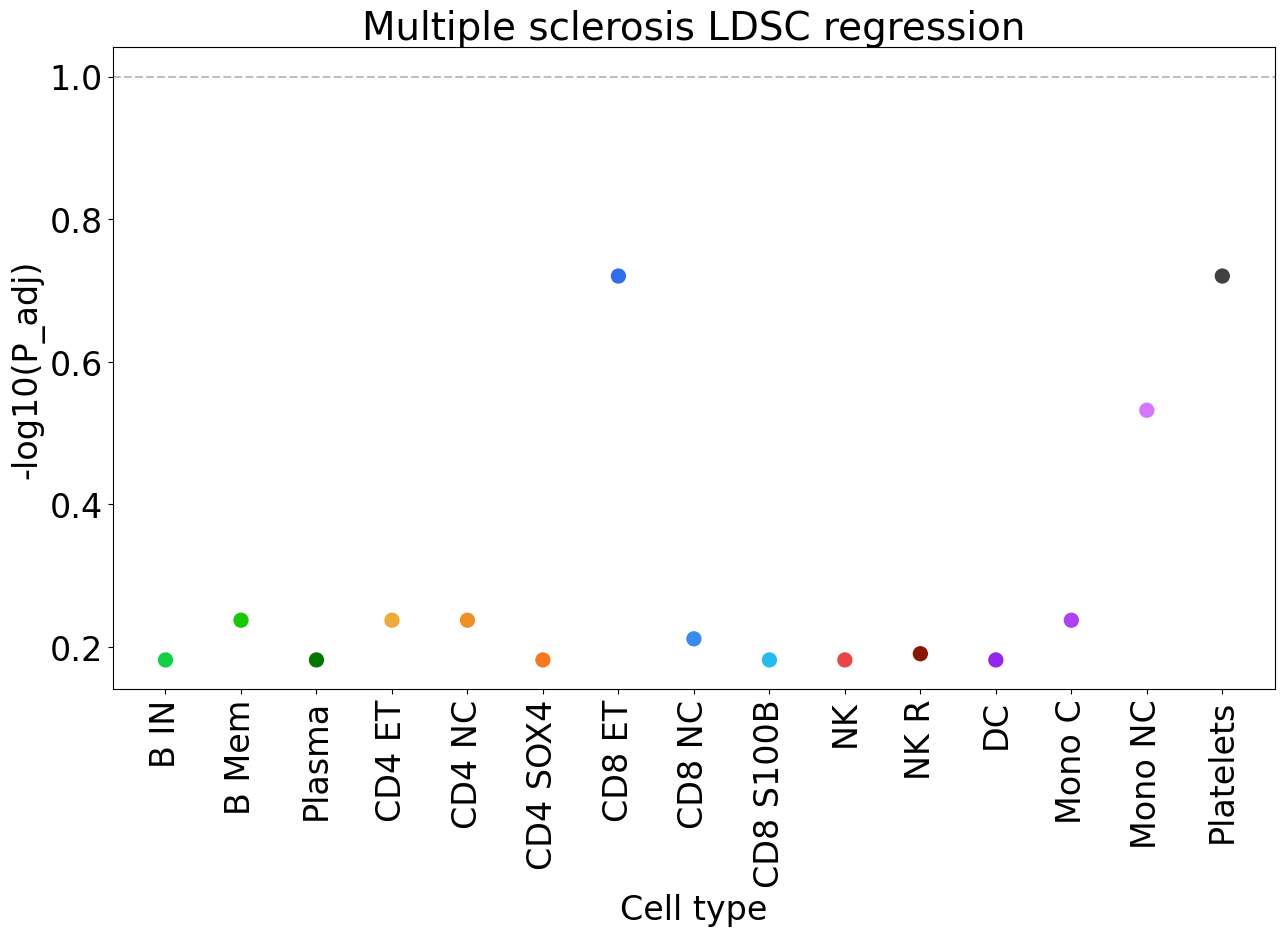

In [311]:
fz=24
p_cutoff = 0.1

plt.figure(figsize=(n_cell_types, n_cell_types/1.8))
plt.scatter(
        range(ldsc_results.shape[0]),
        -np.log10(ldsc_results['P_adj']),
        c=[ct_colour_dict[ct] for ct in list(ldsc_results.index)],
        s=100
    )

plt.xlabel("Cell type", fontsize=fz)
plt.ylabel("-log10(P_adj)", fontsize=fz)

plt.title('Multiple sclerosis LDSC regression', fontsize=fz + 4)
plt.xticks(range(ldsc_results.shape[0]),
           labels=[ct.replace("_", " ") for ct in ldsc_results.index.values],
           rotation=90, fontsize=fz)
plt.yticks(fontsize=fz)

plt.axhline(-np.log10(p_cutoff), linestyle="--", c="grey", alpha=0.5)

plt.show()